In [9]:
from prompting.datasets.wiki import WikiDataset
dataset = WikiDataset()

samples = []
for i in range(1000):
    samples.append(dataset.random())

/workspace/prompting/.venv/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /workspace/prompting/.venv/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
2024-10-13 18:31:54.080 | DEBUG    | prompting.datasets.wiki:_get_page:31 - DisambiguationError loading page 'WBBZ': "WBBZ" may refer to: 
WBBZ (AM)
WBBZ-TV
2024-10-13 18:37:45.624 | DEBUG    | prompting.datasets.wiki:_get_page:31 - DisambiguationError loading page 'Efflux': "Efflux" may refer to: 
Efflux (microbiology)
e-

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│   3                                                                                              │
│   4 samples = []                                                                                 │
│   5 for i in range(1000):                                                                        │
│ ❱ 6 │   samples.append(dataset.random())                                                         │
│   7                                                                                              │
│                                                                                                  │
│ /workspace/prompting/prompting/datasets/wiki.py:207 in random                                    │
│                                                                                                  │
│   204 │   def random(self, pages=10) -> dict:                                                    │
│   205 │   │   titles = _get_random_titles(pages=pages)                                           │
│   206 │   │   for title in titles[: self.max_tries]:                                             │
│ ❱ 207 │   │   │   if context := self.get(title):                                                 │
│   208 │   │   │   │   return context                                                             │
│   209 │   │   return None                                                                        │
│   210                                                                                            │
│                                                                                                  │
│ /workspace/prompting/prompting/datasets/wiki.py:185 in get                                       │
│                                                                                                  │
│   182 │   │   │   content=section_title,                                                         │
│   183 │   │   │   internal_links=list(filter(lambda x: x not in exclude, page.sections)),        │
│   184 │   │   │   external_links=most_relevant_links(page, num_links=self.max_links),            │
│ ❱ 185 │   │   │   tags=filter_categories(page.categories, exclude=self.EXCLUDE_CATEGORIES),      │
│   186 │   │   │   source="Wikipedia",                                                            │
│   187 │   │   │   extra={                                                                        │
│   188 │   │   │   │   "url": page.url,                                                           │
│                                                                                                  │
│ /workspace/prompting/.venv/lib/python3.11/site-packages/wikipedia/wikipedia.py:626 in categories │
│                                                                                                  │
│   623 │                                                                                          │
│   624 │   if not getattr(self, '_categories', False):                                            │
│   625 │     self._categories = [re.sub(r'^Category:', '', x) for x in                            │
│ ❱ 626 │   │   [link['title']                                                                     │
│   627 │   │   for link in self.__continued_query({                                               │
│   628 │   │     'prop': 'categories',                                                            │
│   629 │   │     'cllimit': 'max'                                                                 │
│                                                                                                  │
│ /workspace/prompting/.venv/lib/python3.11/site-packages/wik

In [10]:
print(len(samples))

402


In [37]:
# Perform the analysis

import re
from typing import List
from collections import defaultdict
import matplotlib.pyplot as plt


def get_length_index(answers: List[str], correct: int) -> int:
    """Returns the index of the correct answer once the answers are sorted by string length."""
    assert len(answers) == 4
    sorted_by_length = sorted(answers, key=len)
    index = sorted_by_length.index(answers[correct])
    # When multiple answers are the same length, return a negative of the index
    for i in range(3,-1,-1):
        if len(sorted_by_length[i]) == len(answers[correct]) and i != index:
            return -i
    return index


def plot_results(prompt_name, questions, answers):
    answer_map = {
        "A": 0,
        "B": 1,
        "C": 2,
        "D": 3
    }
    
    # Convert the answer into an index.
    correct_answers = [answer_map[a] for a in answers]

    r = "\[Input Question\]\s+(.*)\s+A\. (.*)\s+B\. (.*)\s+C\. (.*)\s+D\. (.*)"
    regex_trim = "\[Input Question\]\s+([\s\S]*)Answer:.*"

    length_counts = defaultdict(list)

    for question, correct in zip(questions, correct_answers):
        match = re.search(r, question)
        if not match:
            print(f"WTF: {question}")
            continue
        
        trimmed_qa = re.search(regex_trim, question).groups()[0]
        four_answers = match.groups()[1:]
        length_counts[get_length_index(four_answers, correct)].append((trimmed_qa, correct))

    x_and_y = [(index, len(items)) for index, items in length_counts.items()]
    x, y = zip(*x_and_y)

    plt.xticks(ticks=range(-3,4))
    bars = plt.bar(x, y)
    total = sum(y)
    
    # Add percentage labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total) * 100
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # x-position (center of the bar)
            height,  # y-position (top of the bar)
            f'{percentage:.2f}%',  # The percentage label
            ha='center',  # Horizontal alignment (centered on the bar)
            va='bottom'  # Vertical alignment (just above the bar)
        )
    plt.xlabel("Index of correct ans by answer length")
    plt.ylabel("Frequency")
    plt.title(prompt_name)
    plt.show()
    print(f"Total samples = {len(questions)}")

Performing analysis on default


2024-10-14 14:29:43.173 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 95.73 toks/s, output: 27.63 toks/s]
2024-10-14 14:29:46.222 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the input context:

{
    "question": "According to FCC records, when was WBBZ first licensed?",
    "A": "Early 1924",
    "B": "September 9, 1925",
    "C": "January 1928",
    "D": "December 1926",
    "answer": "B"
}
2024-10-14 14:29:46.223 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it, est. speed input: 143.16 toks/s, output: 27.07 toks/s]
2024-10-14 14:29:48.407 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What was the year Johan Nordhag

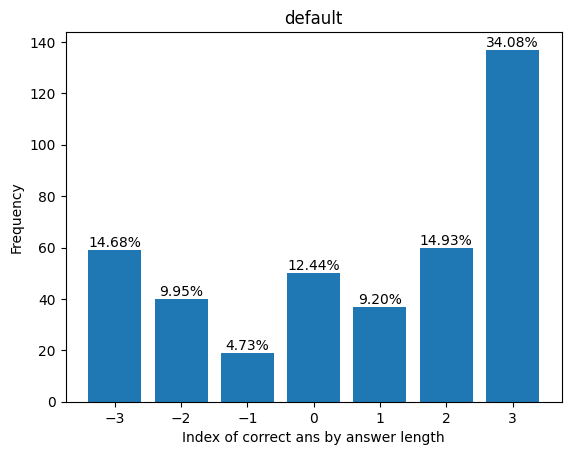

Total samples = 402
Performing analysis on length_instructions


2024-10-14 14:52:02.629 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it, est. speed input: 101.21 toks/s, output: 28.06 toks/s]
2024-10-14 14:52:05.627 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the provided context:

{
    "question": "According to FCC records, when was WBBZ first licensed?",
    "A": "January 1928",
    "B": "September 9, 1925",
    "C": "Early 1924",
    "D": "December 1926",
    "answer": "B"
}
2024-10-14 14:52:05.628 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, est. speed input: 125.78 toks/s, output: 27.17 toks/s]
2024-10-14 14:52:08.208 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the co

Failed to create sample for length_instructions


2024-10-14 14:57:03.333 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it, est. speed input: 95.07 toks/s, output: 28.00 toks/s]
2024-10-14 14:57:06.767 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the context:

{
    "question": "Which couple was crowned the ultimate title of 'Super Jodi'?",
    "A": "Rajkumar and Shamili Sukumar",
    "B": "Vishwa Sam and Nakshatra",
    "C": "Selvakumar and Chinnaponnu",
    "D": "Sukumar and Shamili",
    "answer": "C"
}
2024-10-14 14:57:06.768 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 110.91 toks/s, output: 27.81 toks/s]
2024-10-14 14:57:09.615 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here i

Failed to create sample for length_instructions


2024-10-14 14:59:49.144 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it, est. speed input: 115.78 toks/s, output: 27.53 toks/s]
2024-10-14 14:59:52.166 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the provided context:

{
    "question": "What is the primary mode of transmission for Herpes gladiatorum?",
    "A": "Through airborne particles",
    "B": "By skin-to-skin contact",
    "C": "Via contaminated food and water",
    "D": "Through insect bites",
    "answer": "B"
}
2024-10-14 14:59:52.167 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it, est. speed input: 89.95 toks/s, output: 28.16 toks/s]
2024-10-14 14:59:56.187 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following 

Failed to create sample for length_instructions


2024-10-14 15:01:59.476 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it, est. speed input: 114.97 toks/s, output: 27.67 toks/s]
2024-10-14 15:02:02.047 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "In which region of Mali is the commune of Falémé located?",
    "A": "Ségou Region",
    "B": "Kayes Region",
    "C": "Mopti Region",
    "D": "Tombouctou Region",
    "answer": "B"
}
2024-10-14 15:02:02.048 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it, est. speed input: 77.62 toks/s, output: 28.58 toks/s]
2024-10-14 15:02:05.869 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the input context:

{
    "question": "On what date did a convoy of

Failed to create sample for length_instructions


2024-10-14 15:06:28.021 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it, est. speed input: 89.79 toks/s, output: 28.28 toks/s]
2024-10-14 15:06:31.457 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the context:

{
    "question": "What is an example of the aza-Wittig reaction being utilized in organic synthesis?",
    "A": "Synthesis of penicillin",
    "B": "Synthesis of (–)-benzomalvin A",
    "C": "Synthesis of aspirin",
    "D": "Synthesis of ibuprofen",
    "answer": "B"
}
2024-10-14 15:06:31.458 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it, est. speed input: 83.95 toks/s, output: 28.47 toks/s]
2024-10-14 15:06:34.870 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the followi

Failed to create sample for length_instructions


2024-10-14 15:08:03.678 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it, est. speed input: 101.72 toks/s, output: 27.84 toks/s]
2024-10-14 15:08:07.310 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the context:

{
    "question": "Where did Sanae Takaichi work as a Congressional Fellow in 1987?",
    "A": "The Japanese Embassy in Washington D.C.",
    "B": "The office of Democratic U.S. Representative Pat Schroeder",
    "C": "The United Nations Headquarters in New York",
    "D": "The U.S. Department of State",
    "answer": "B"
}
2024-10-14 15:08:07.311 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it, est. speed input: 87.16 toks/s, output: 28.19 toks/s]
2024-10-14 15:08:11.182 | INFO     | prompting.llm

Failed to create sample for length_instructions


2024-10-14 15:10:40.440 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 89.71 toks/s, output: 28.30 toks/s]
2024-10-14 15:10:43.768 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the provided context:

{
    "question": "When was the Japanese single 'Startup!' by Boyfriend physically released?",
    "A": "May 27, 2013",
    "B": "May 28, 2014",
    "C": "June 1, 2015",
    "D": "April 25, 2016",
    "answer": "B"
}
2024-10-14 15:10:43.770 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it, est. speed input: 78.88 toks/s, output: 28.58 toks/s]
2024-10-14 15:10:47.414 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz b

Failed to create sample for length_instructions


2024-10-14 15:11:11.299 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 115.26 toks/s, output: 27.52 toks/s]
2024-10-14 15:11:14.395 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the provided context:

{
    "question": "Who donated the Roddick Gates to McGill University in 1924?",
    "A": "Sir Thomas George Roddick",
    "B": "Amy Redpath Roddick",
    "C": "John James Redpath",
    "D": "Ada Mills",
    "answer": "B"
}
2024-10-14 15:11:14.396 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 104.30 toks/s, output: 27.85 toks/s]
2024-10-14 15:11:17.777 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choi

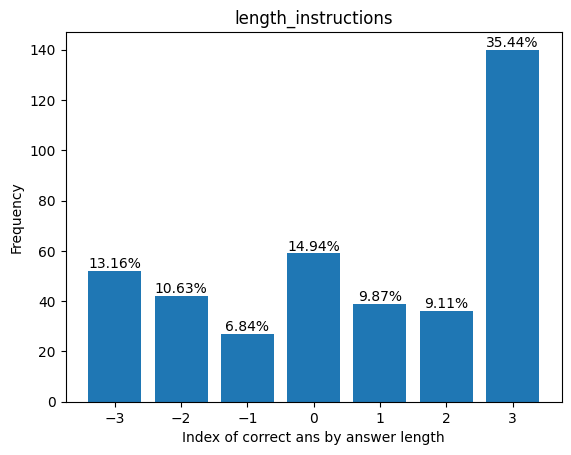

Total samples = 395
Performing analysis on more_examples


2024-10-14 15:15:17.886 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it, est. speed input: 149.79 toks/s, output: 26.59 toks/s]
2024-10-14 15:15:20.977 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is the multiple choice quiz:

{
    "question": "According to FCC records, when was WBBZ first licensed?",
    "A": "January 1924",
    "B": "September 9, 1925",
    "C": "January 1928",
    "D": "September 9, 1926",
    "answer": "B"
}
2024-10-14 15:15:20.978 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, est. speed input: 168.03 toks/s, output: 26.09 toks/s]
2024-10-14 15:15:23.860 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the context:

{
    "questio

Failed to create sample for more_examples


2024-10-14 15:16:43.426 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it, est. speed input: 139.40 toks/s, output: 26.84 toks/s]
2024-10-14 15:16:46.896 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the context:

{
    "question": "What is the name of the director and writer of the 2020 Iranian drama film 'Tooman'?",
    "A": "Morteza Najafi",
    "B": "Morteza Farshbaf",
    "C": "Mohammad Farhadi",
    "D": "Ali Abassi",
    "answer": "B"
}
2024-10-14 15:16:46.897 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, est. speed input: 172.02 toks/s, output: 26.00 toks/s]
2024-10-14 15:16:49.710 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "In 

Failed to create sample for more_examples


2024-10-14 15:17:06.151 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it, est. speed input: 102.93 toks/s, output: 27.72 toks/s]
2024-10-14 15:17:10.558 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the input context:

{
    "question": "Which of the following media outlets has interviewed or profiled students, alumni, and professors of The Art Institute of Charlotte?",
    "A": "The New York Times, CNN, and Fox News",
    "B": "The Charlotte Observer, The San Jose Mercury News, and NBC affiliate WCNC-TV",
    "C": "The Los Angeles Times, USA Today, and CBS News",
    "D": "The Wall Street Journal, ESPN, and MTV",
    "answer": "B"
}
2024-10-14 15:17:10.559 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it, e

Failed to create sample for more_examples


2024-10-14 15:19:40.934 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 155.94 toks/s, output: 26.63 toks/s]
2024-10-14 15:19:44.321 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the input context:

{
    "question": "Who led the Liberal party from 23 May 1989 to 23 April 1991 after Jeff Kennett was voted out?",
    "A": "Brian Costar",
    "B": "Alan Brown",
    "C": "Jeff Kennett",
    "D": "Bob Hawke",
    "answer": "B"
}
2024-10-14 15:19:44.322 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it, est. speed input: 151.98 toks/s, output: 26.67 toks/s]
2024-10-14 15:19:47.817 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple c

Failed to create sample for more_examples


2024-10-14 15:20:26.758 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it, est. speed input: 141.41 toks/s, output: 26.94 toks/s]
2024-10-14 15:20:29.884 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the provided context:

{
    "question": "What is the average length of a bearded fireworm?",
    "A": "10 cm (4 inches)",
    "B": "15 cm (6 inches)",
    "C": "20 cm (8 inches)",
    "D": "25 cm (10 inches)",
    "answer": "B"
}
2024-10-14 15:20:29.885 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it, est. speed input: 141.71 toks/s, output: 27.12 toks/s]
2024-10-14 15:20:33.505 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on

Failed to create sample for more_examples


2024-10-14 15:33:55.367 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it, est. speed input: 124.26 toks/s, output: 27.12 toks/s]
2024-10-14 15:33:58.985 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the provided context:

{
    "question": "What is one way postal codes in Canada can be used in conjunction with other data?",
    "A": "To track package delivery times",
    "B": "To create a geographic profile of an area's population",
    "C": "To monitor weather patterns across the country",
    "D": "To analyze traffic congestion in urban areas",
    "answer": "B"
}
2024-10-14 15:33:58.986 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it, est. speed input: 145.53 toks/s, output: 26.61 toks/s]
2024-10-14 15:3

Failed to create sample for more_examples


2024-10-14 15:34:31.264 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it, est. speed input: 154.95 toks/s, output: 26.39 toks/s]
2024-10-14 15:34:34.226 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the provided context:

{
    "question": "What is the title of the Japanese-language song and sixth Japanese single album by Boyfriend?",
    "A": "Rise Up!",
    "B": "Startup!",
    "C": "Launch Now!",
    "D": "Begin Again!",
    "answer": "B"
}
2024-10-14 15:34:34.226 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 131.84 toks/s, output: 27.20 toks/s]
2024-10-14 15:34:37.613 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple ch

Failed to create sample for more_examples


2024-10-14 15:35:29.246 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it, est. speed input: 129.61 toks/s, output: 27.19 toks/s]
2024-10-14 15:35:33.186 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the provided context:

{
    "question": "What award did Lee receive a nomination for in 2020 for his portrayal of Bear Sylvester?",
    "A": "Best Dramatic Performance at the British Soap Awards",
    "B": "Best Leading Performer at the British Soap Awards",
    "C": "Best Daytime Star at the Inside Soap Awards",
    "D": "Best Storyline at the British Soap Awards",
    "answer": "C"
}
2024-10-14 15:35:33.186 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it, est. speed input: 154.53 toks/s, output: 26.46 toks/s]

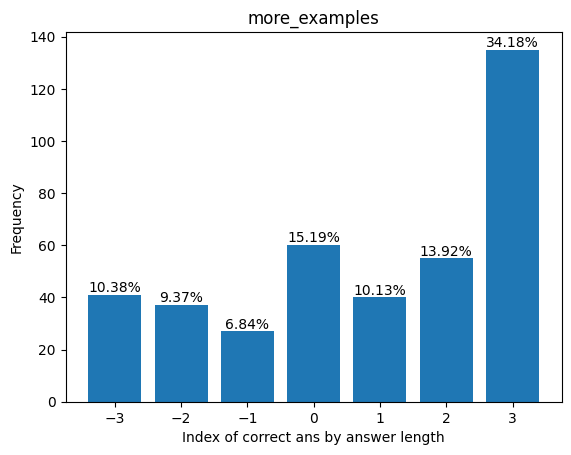

Total samples = 395
Performing analysis on more_examples_and_length


2024-10-14 15:39:19.513 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 151.55 toks/s, output: 26.54 toks/s]
2024-10-14 15:39:22.646 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the context:

{
    "question": "According to FCC records, when was WBBZ first licensed?",
    "A": "January 1928",
    "B": "September 9, 1925",
    "C": "Early 1924",
    "D": "December 1922",
    "answer": "B"
}
2024-10-14 15:39:22.647 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it, est. speed input: 146.98 toks/s, output: 26.72 toks/s]
2024-10-14 15:39:26.019 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the provided co

Failed to create sample for more_examples_and_length


2024-10-14 15:40:48.090 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it, est. speed input: 129.29 toks/s, output: 27.16 toks/s]
2024-10-14 15:40:51.924 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What was the outcome for Morteza Najafi at the 38th Fajr Film Festival for his work on the film Tooman?",
    "A": "He won a Crystal Simorgh for Best Director",
    "B": "He won a Crystal Simorgh for Best Cinematography",
    "C": "He received a nomination for Best Actor",
    "D": "He received a nomination for Best Screenplay",
    "answer": "B"
}
2024-10-14 15:40:51.925 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it, est. speed input: 162.87 toks/s, output: 26.32 toks/s]
2024-10-14 15:40:54.969 | INFO     | prompting.llms.vllm_ll

Failed to create sample for more_examples_and_length


2024-10-14 15:42:08.028 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.97s/it, est. speed input: 72.58 toks/s, output: 28.54 toks/s]
2024-10-14 15:42:17.004 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the context:

{
    "question": "When were the Ministry of Defence and the General Staff of the Abkhazian armed forces officially created?",
    "A": "12 October 1991",
    "B": "12 October 1992",
    "C": "12 October 1993",
    "D": "12 October 1994",
    "answer": "B"
}

Or

{
    "question": "What was the approximate number of Georgian civilians that became Internally displaced persons (IDPs) during the 1992-1993 war?",
    "A": "100,000 to 150,000",
    "B": "200,000 to 250,000",
    "C": "300,000 to 350,000",
    "D": "400,000 to 450,000",
    "answer": "B"
}

Or

{
    "question": "Where did most of the

Failed to create sample for more_examples_and_length


2024-10-14 15:42:17.005 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it, est. speed input: 153.64 toks/s, output: 26.70 toks/s]
2024-10-14 15:42:20.532 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the context:

{
    "question": "Who founded God's Bible School, which later became God's Bible School and College?",
    "A": "Martin Luther King Jr.",
    "B": "Martin Wells Knapp",
    "C": "John Wesley",
    "D": "Charles Finney",
    "answer": "B"
}

Let me know if you'd like me to create another one!
2024-10-14 15:42:20.533 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.83s/it, est. speed input: 104.99 toks/s, output: 27.75 toks/s]
2024-10-14 15:42:25.367 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_

Failed to create sample for more_examples_and_length


2024-10-14 15:45:52.187 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it, est. speed input: 119.46 toks/s, output: 27.38 toks/s]
2024-10-14 15:45:56.210 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the context:

{
    "question": "Where was Abdorrasul Zarrin born?",
    "A": "Dehdasht",
    "B": "Qaleh Gol",
    "C": "Tehran",
    "D": "Shiraz",
    "answer": "B"
}

Note: I chose Qaleh Gol as the correct answer since the text states he was born in the village of Qaleh Gol, near Dehdasht.
2024-10-14 15:45:56.211 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it, est. speed input: 140.51 toks/s, output: 26.75 toks/s]
2024-10-14 15:45:59.468 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated

Failed to create sample for more_examples_and_length


2024-10-14 15:47:13.750 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it, est. speed input: 160.06 toks/s, output: 26.47 toks/s]
2024-10-14 15:47:17.004 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What was the result of the Treaty of Saint-Germain-en-Laye for Acadia in 1632?",
    "A": "It became a British colony",
    "B": "It gained independence from France",
    "C": "It reverted to French control",
    "D": "It was ceded to the Spanish Empire",
    "answer": "C"
}
2024-10-14 15:47:17.004 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it, est. speed input: 149.38 toks/s, output: 26.78 toks/s]
2024-10-14 15:47:20.630 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multi

Failed to create sample for more_examples_and_length


2024-10-14 15:48:30.607 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it, est. speed input: 168.31 toks/s, output: 26.31 toks/s]
2024-10-14 15:48:33.958 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the context:

{
    "question": "What is the gameplay of Fragger similar to?",
    "A": "Candy Crush Saga",
    "B": "Fruit Ninja",
    "C": "Angry Birds",
    "D": "Plants vs. Zombies",
    "answer": "C"
}

Let me know if you want me to create another question!
2024-10-14 15:48:33.959 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 150.99 toks/s, output: 26.55 toks/s]
2024-10-14 15:48:37.090 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is

Failed to create sample for more_examples_and_length


2024-10-14 15:49:05.298 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it, est. speed input: 126.71 toks/s, output: 27.21 toks/s]
2024-10-14 15:49:09.163 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the context:

{
    "question": "What is the characteristic of the achenes of Cotula alpina as the seed matures?",
    "A": "They become heavier and more compact",
    "B": "They loosen towards the base and develop a smooth appearance",
    "C": "They loosen towards the top and develop a fluffy appearance",
    "D": "They become brittle and prone to shattering",
    "answer": "C"
}
2024-10-14 15:49:09.163 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it, est. speed input: 148.35 toks/s, output: 26.53 toks/s]
2024

Failed to create sample for more_examples_and_length


2024-10-14 15:49:29.438 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it, est. speed input: 149.58 toks/s, output: 26.69 toks/s]
2024-10-14 15:49:32.853 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What is one of the graduate degree programs offered by Christian Theological Seminary?",
    "A": "Master of Business Administration (MBA)",
    "B": "Master of Arts in Clinical Mental Health Counseling (MACMHC)",
    "C": "Master of Science in Computer Science (MSCS)",
    "D": "Master of Public Administration (MPA)",
    "answer": "B"
}
2024-10-14 15:49:32.854 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it, est. speed input: 110.06 toks/s, output: 27.57 toks/s]
2024-10-14 15:49:37.065 | INFO     | prompting.llms.vllm_llm:_forward

Failed to create sample for more_examples_and_length


2024-10-14 15:50:43.319 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it, est. speed input: 135.30 toks/s, output: 27.11 toks/s]
2024-10-14 15:50:47.271 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the context:

{
    "question": "Where was the sample of Staphylococcus cornubiensis first collected?",
    "A": "A hospital in London, England",
    "B": "A patient in Cornwall, United Kingdom",
    "C": "A laboratory in Wales, United Kingdom",
    "D": "A research facility in Scotland, United Kingdom",
    "answer": "B"
}

Let me know if you want me to generate another question!
2024-10-14 15:50:47.271 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.73s/it, est. speed input: 109.52 toks/s, output: 27.70 toks/s]
2024-

Failed to create sample for more_examples_and_length


2024-10-14 15:52:17.176 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it, est. speed input: 133.14 toks/s, output: 27.13 toks/s]
2024-10-14 15:52:21.163 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is the generated quiz:

{
    "question": "What action did Mufti Amjad Mohammed take regarding Muslim investment in OneCoin?",
    "A": "He issued a fatwa in support of investing in OneCoin",
    "B": "He issued a fatwa advising against investing in OneCoin",
    "C": "He remained neutral on the matter and did not comment publicly",
    "D": "He partnered with OneCoin to promote it to Muslim investors",
    "answer": "B"
}
2024-10-14 15:52:21.164 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it, est. speed input: 161.63 toks/s, output: 26.27 toks/

Failed to create sample for more_examples_and_length


2024-10-14 15:54:15.356 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.12s/it, est. speed input: 74.08 toks/s, output: 28.45 toks/s]
2024-10-14 15:54:21.480 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the provided context:

{
    "question": "Which of the following individuals appeared as themselves in the radio series 'One'?",
    "A": "Graeme Garden",
    "B": "Jeremy Clarkson",
    "C": "Lizzie Roper",
    "D": "Simon Greenall",
    "answer": "B"
}

Let me know if you'd like me to generate another one!

Edit: Here's another one:

{
    "question": "Who among the following is not a performer who appeared as a character in the radio series 'One'?",
    "A": "Dan Antopolski",
    "B": "Deborah Norton",
    "C": "Jeremy Clarkson",
    "D": "Graeme Garden",
    "answer": "C"
}


Failed to create sample for more_examples_and_length


2024-10-14 15:54:21.482 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it, est. speed input: 164.22 toks/s, output: 26.38 toks/s]
2024-10-14 15:54:25.015 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the input context:

{
    "question": "What was the title of the TV episode that featured the case of John Brennan Crutchley?",
    "A": "American Monsters",
    "B": "American Occult",
    "C": "American Crimes",
    "D": "American Justice",
    "answer": "B"
}

Let me know if you'd like me to generate another question!
2024-10-14 15:54:25.016 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it, est. speed input: 118.35 toks/s, output: 27.29 toks/s]
2024-10-14 15:54:28.834 | INFO     | prompting.llms.vllm_llm:_forw

Failed to create sample for more_examples_and_length


2024-10-14 15:59:07.450 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, est. speed input: 125.30 toks/s, output: 27.18 toks/s]
2024-10-14 15:59:11.138 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What is one potential use of correlating postal codes with databased information from censuses or health registries?",
    "A": "Determining the average household income of a neighborhood",
    "B": "Identifying areas with high concentrations of small businesses",
    "C": "Creating a geographic profile of an area's population",
    "D": "Tracking the movement of goods and services across the country",
    "answer": "C"
}
2024-10-14 15:59:11.139 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 168.59 toks/s, output

Failed to create sample for more_examples_and_length


2024-10-14 15:59:42.427 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 151.60 toks/s, output: 26.50 toks/s]
2024-10-14 15:59:45.528 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple choice quiz based on the provided context:

{
    "question": "What is the title of the Japanese-language song and sixth Japanese single by the South Korean boy band Boyfriend?",
    "A": "Rise Up",
    "B": "Startup!",
    "C": "Take Off",
    "D": "Launch Day",
    "answer": "B"
}
2024-10-14 15:59:45.529 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it, est. speed input: 108.05 toks/s, output: 27.60 toks/s]
2024-10-14 15:59:49.775 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is

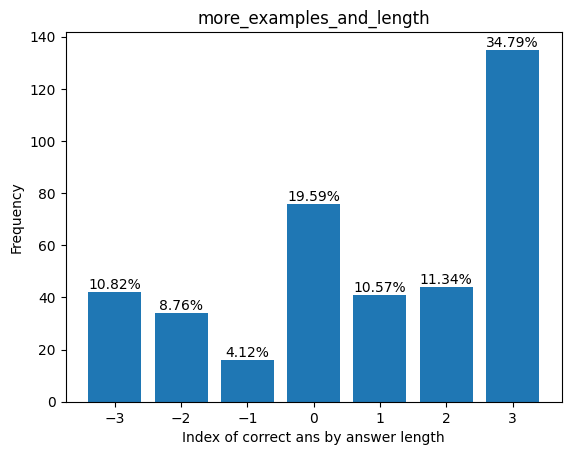

Total samples = 388
Performing analysis on formatted_instructions


2024-10-14 16:04:34.369 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it, est. speed input: 166.97 toks/s, output: 26.20 toks/s]
2024-10-14 16:04:37.236 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "According to FCC records, when was WBBZ first licensed?",
    "A": "January 1924",
    "B": "September 9, 1925",
    "C": "January 1928",
    "D": "September 9, 1928",
    "answer": "B"
}
2024-10-14 16:04:37.237 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it, est. speed input: 181.40 toks/s, output: 25.81 toks/s]
2024-10-14 16:04:39.992 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple-choice question based on the input context:

{
    "question": "In what year did Joh

Failed to create sample for formatted_instructions


2024-10-14 16:05:53.365 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it, est. speed input: 138.35 toks/s, output: 26.89 toks/s]
2024-10-14 16:05:56.978 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple-choice question based on the provided context:

{
    "question": "What award did Morteza Najafi win for his work on the film Tooman?",
    "A": "Crystal Simorgh for Best Direction",
    "B": "Crystal Simorgh for Best Cinematography",
    "C": "Crystal Simorgh for Best Screenplay",
    "D": "Crystal Simorgh for Best Editing",
    "answer": "B"
}
2024-10-14 16:05:56.979 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 190.46 toks/s, output: 25.57 toks/s]
2024-10-14 16:05:59.605 | INFO     | prompting.llms.vllm_llm:_

Failed to create sample for formatted_instructions


2024-10-14 16:06:09.630 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 145.38 toks/s, output: 26.66 toks/s]
2024-10-14 16:06:12.867 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple-choice question based on the provided context:

{
    "question": "Which of the following media outlets has featured The Art Institute of Charlotte's students, alumni, or professors?",
    "A": "The New York Times",
    "B": "The Charlotte Observer",
    "C": "The Washington Post",
    "D": "Los Angeles Times",
    "answer": "B"
}
2024-10-14 16:06:12.868 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it, est. speed input: 131.57 toks/s, output: 27.16 toks/s]
2024-10-14 16:06:16.887 | INFO     | prompting.llms.vllm_llm:_forward:194 - v

Failed to create sample for formatted_instructions


2024-10-14 16:10:31.534 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, est. speed input: 202.03 toks/s, output: 25.31 toks/s]
2024-10-14 16:10:33.910 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What is Erika Eiffel's other known name?",
    "A": "Ava",
    "B": "Eva",
    "C": "Aya",
    "D": "Ella",
    "answer": "C"
}
2024-10-14 16:10:33.911 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 184.35 toks/s, output: 25.88 toks/s]
2024-10-14 16:10:36.736 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "In what year was the Chinatown Art Brigade co-founded by Tomie Arai, ManSee Kong, and Betty Yu?",
    "A": "2010",
    "B": "2012",
    "C": "20

Failed to create sample for formatted_instructions


2024-10-14 16:15:53.634 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it, est. speed input: 158.28 toks/s, output: 26.61 toks/s]
2024-10-14 16:15:57.247 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple-choice question based on the context:

{
    "question": "What is the occupation of Rick Neuheisel's father, Richard 'Dick' Gerald Neuheisel Sr.?",
    "A": "Coach at UCLA",
    "B": "Attorney and past president of Sister Cities International",
    "C": "Quarterback for Arizona",
    "D": "Wide receiver at Southern Methodist University",
    "answer": "B"
}
2024-10-14 16:15:57.248 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it, est. speed input: 153.71 toks/s, output: 26.64 toks/s]
2024-10-14 16:16:00.670 | INFO     | prompting.llm

Failed to create sample for formatted_instructions


2024-10-14 16:21:48.234 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it, est. speed input: 134.48 toks/s, output: 26.90 toks/s]
2024-10-14 16:21:51.699 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "According to the provided information, what type of data has been used in conjunction with postal codes in Canada to analyze population characteristics?",
    "A": "Traffic patterns and road usage",
    "B": "Databased information from censuses or health registries",
    "C": "Weather patterns and climate data",
    "D": "Economic indicators and market trends",
    "answer": "B"
}
2024-10-14 16:21:51.700 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it, est. speed input: 187.76 toks/s, output: 25.57 toks/s]
2024-10-14 16:21:54.211 | 

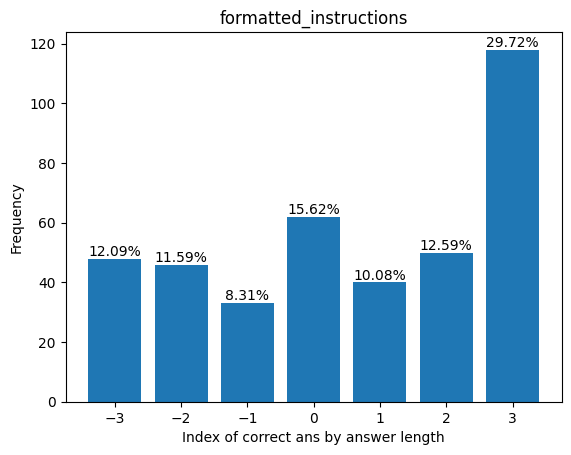

Total samples = 397
Performing analysis on formatted_instructions_simple_user


2024-10-14 16:26:46.044 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, est. speed input: 170.90 toks/s, output: 26.07 toks/s]
2024-10-14 16:26:48.813 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "According to FCC records, when was WBBZ first licensed?",
    "A": "January 1928",
    "B": "September 9, 1925",
    "C": "early 1924",
    "D": "December 1926",
    "answer": "B"
}
2024-10-14 16:26:48.814 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it, est. speed input: 173.58 toks/s, output: 26.05 toks/s]
2024-10-14 16:26:51.662 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "Who was Johan Nordhagen married to?",
    "A": "Christine Magdalene Brochmann Johansen",
 

Failed to create sample for formatted_instructions_simple_user


2024-10-14 16:37:00.049 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 203.12 toks/s, output: 25.53 toks/s]
2024-10-14 16:37:02.837 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What high school did Jerry and Jack Neuheisel attend?",
    "A": "UCLA High School",
    "B": "Loyola High School in Los Angeles",
    "C": "Southern Methodist High School",
    "D": "Arizona High School",
    "answer": "B"
}
2024-10-14 16:37:02.838 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.88s/it, est. speed input: 133.98 toks/s, output: 27.10 toks/s]
2024-10-14 16:37:06.720 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What was the result of the Bhutanese governmen

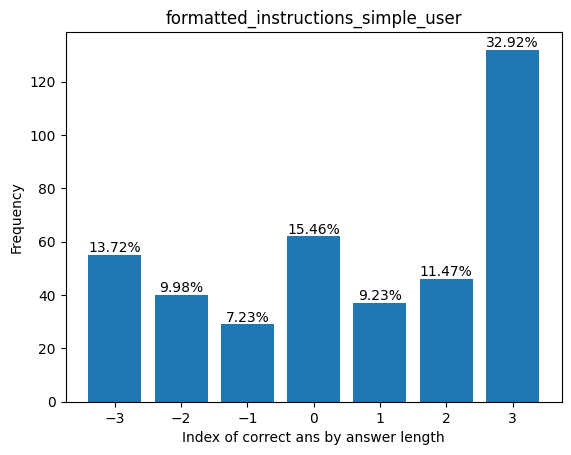

Total samples = 401
Performing analysis on formatted_instructions_with_length_user_prompt


2024-10-14 16:46:50.263 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it, est. speed input: 142.77 toks/s, output: 26.81 toks/s]
2024-10-14 16:46:53.703 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple-choice question based on the context:

{
    "question": "According to FCC records, when was WBBZ first licensed?",
    "A": "September 9, 1924",
    "B": "September 9, 1925",
    "C": "January 8, 1928",
    "D": "December 31, 1929",
    "answer": "B"
}
2024-10-14 16:46:53.704 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 151.34 toks/s, output: 26.65 toks/s]
2024-10-14 16:46:57.087 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple-choice question ba

Failed to create sample for formatted_instructions_with_length_user_prompt


2024-10-14 16:53:33.982 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it, est. speed input: 204.34 toks/s, output: 25.54 toks/s]
2024-10-14 16:53:36.887 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What is the occupation of Vince Perrino in the story 'City in Fear'?",
    "A": "LAPD Detective",
    "B": "Grocery Store Employee",
    "C": "Newspaper Columnist",
    "D": "Wealthy Publisher",
    "answer": "C"
}
2024-10-14 16:53:36.888 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, est. speed input: 147.27 toks/s, output: 26.72 toks/s]
2024-10-14 16:53:40.338 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple-choice question based on the provided context:

{
    "qu

Failed to create sample for formatted_instructions_with_length_user_prompt


2024-10-14 16:57:30.633 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it, est. speed input: 136.99 toks/s, output: 26.89 toks/s]
2024-10-14 16:57:34.171 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple-choice question based on the provided context:

{
    "question": "What tone has been used to describe the album Too Many Humans?",
    "A": "Uplifting and optimistic",
    "B": "Violent, misanthropic, noisy, and mean-spirited",
    "C": "Playful and sarcastic",
    "D": "Melancholic and introspective",
    "answer": "B"
}
2024-10-14 16:57:34.172 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it, est. speed input: 159.71 toks/s, output: 26.57 toks/s]
2024-10-14 16:57:37.715 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM 

Failed to create sample for formatted_instructions_with_length_user_prompt


2024-10-14 17:03:05.339 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it, est. speed input: 131.91 toks/s, output: 27.19 toks/s]
2024-10-14 17:03:09.317 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple-choice question based on the provided context:

{
    "question": "What is notable about the musical style of Synthetiklezmer?",
    "A": "It combines mariachi with electronic elements",
    "B": "It fuses sephardic fanfare sounds and klezmer with modern electronic instruments",
    "C": "It blends salsa with traditional Mexican folk music",
    "D": "It features a mix of jazz and classical music",
    "answer": "B"
}
2024-10-14 17:03:09.318 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 152.16 toks/s, output: 26

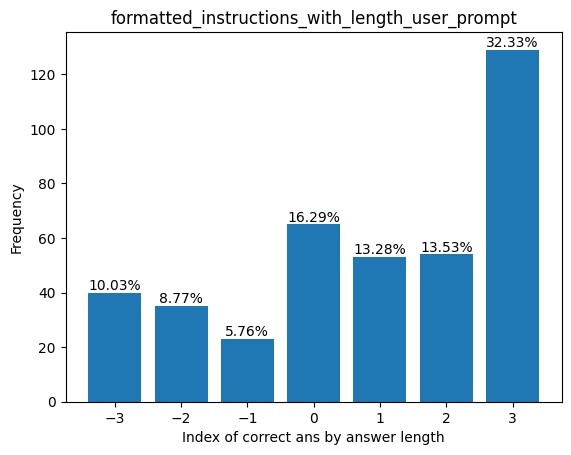

Total samples = 399
Performing analysis on make_answer_short


2024-10-14 17:10:03.272 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it, est. speed input: 167.69 toks/s, output: 26.15 toks/s]
2024-10-14 17:10:06.147 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "According to FCC records, when was WBBZ first licensed?",
    "A": "Early 1924",
    "B": "January 1928",
    "C": "September 9, 1925",
    "D": "December 31, 1923",
    "answer": "C"
}
2024-10-14 17:10:06.148 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it, est. speed input: 191.66 toks/s, output: 25.58 toks/s]
2024-10-14 17:10:08.774 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What was Johan Nordhagen's age at the time of his death?",
    "A": 80 years old,
    

Failed to create sample for make_answer_short


2024-10-14 17:10:08.776 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 174.55 toks/s, output: 25.98 toks/s]
2024-10-14 17:10:11.515 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What was Frances Teresa Shea-Buckley's rank in the United States Navy?",
    "A": "Lieutenant Commander",
    "B": "Rear Admiral",
    "C": "Vice Admiral",
    "D": "Admiral of the Fleet",
    "answer": "B"
}
2024-10-14 17:10:11.516 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it, est. speed input: 186.76 toks/s, output: 25.72 toks/s]
2024-10-14 17:10:15.101 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What type of window is located on the east end of Anchorite's C

Failed to create sample for make_answer_short


2024-10-14 17:10:18.418 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, est. speed input: 192.22 toks/s, output: 25.46 toks/s]
2024-10-14 17:10:20.859 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What genre is the band Novelists primarily associated with?",
    "A": "Progressive rock",
    "B": "Metalcore",
    "C": "Hardcore punk",
    "D": "Thrash metal",
    "answer": "B"
}
2024-10-14 17:10:20.860 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it, est. speed input: 163.81 toks/s, output: 26.48 toks/s]
2024-10-14 17:10:24.531 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple-choice question based on the input context:

{
    "question": "Which team did Michael K

Failed to create sample for make_answer_short


2024-10-14 17:14:23.967 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, est. speed input: 166.75 toks/s, output: 26.10 toks/s]
2024-10-14 17:14:26.731 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple-choice question based on the provided context:

{
    "question": "What is the average length of a bearded fireworm?",
    "A": "30 cm",
    "B": "15 cm",
    "C": "60 cm",
    "D": "12 inches",
    "answer": "B"
}
2024-10-14 17:14:26.731 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it, est. speed input: 164.72 toks/s, output: 26.37 toks/s]
2024-10-14 17:14:29.962 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple-choice question based on the provided context:

{
    "qu

Failed to create sample for make_answer_short


2024-10-14 17:19:27.895 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it, est. speed input: 171.27 toks/s, output: 25.98 toks/s]
2024-10-14 17:19:30.634 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "Where did Judith A. LaRocque receive her Master of Arts degree in Public Administration?",
    "A": "University of Ottawa",
    "B": "McMaster University",
    "C": "Carleton University",
    "D": "University of Toronto",
    "answer": "C"
}
2024-10-14 17:19:30.635 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 162.56 toks/s, output: 26.14 toks/s]
2024-10-14 17:19:33.435 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple-choice question based on the i

Failed to create sample for make_answer_short


2024-10-14 17:19:40.953 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it, est. speed input: 179.84 toks/s, output: 26.11 toks/s]
2024-10-14 17:19:44.063 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "When was the current Library of the Legislative Power of Uruguay founded?",
    "A": "August 24, 1928",
    "B": "August 25, 1929",
    "C": "August 26, 1930",
    "D": "August 27, 1931",
    "answer": "B"
}
2024-10-14 17:19:44.065 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it, est. speed input: 194.40 toks/s, output: 25.49 toks/s]
2024-10-14 17:19:46.581 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What is the apparent visual magnitude of φ Eridani?",
    "A": "

Failed to create sample for make_answer_short


2024-10-14 17:24:22.767 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it, est. speed input: 156.45 toks/s, output: 26.52 toks/s]
2024-10-14 17:24:26.131 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is the multiple-choice question based on the input context:

{
    "question": "When was the Sembiran inscription dated to?",
    "A": "897 Saka (1025 CE)",
    "B": "897 Saka (975 CE)",
    "C": "1097 Saka (1175 CE)",
    "D": "797 Saka (875 CE)",
    "answer": "B"
}
2024-10-14 17:24:26.132 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it, est. speed input: 184.31 toks/s, output: 26.08 toks/s]
2024-10-14 17:24:29.514 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here is a multiple-choice question b

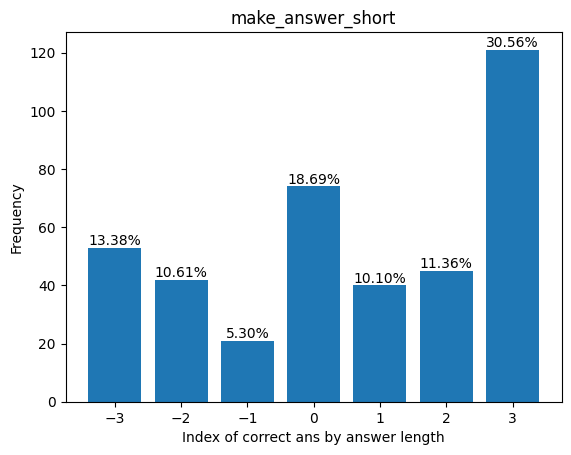

Total samples = 396
Performing analysis on more_rules


2024-10-14 17:31:09.723 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it, est. speed input: 223.82 toks/s, output: 25.22 toks/s]
2024-10-14 17:31:12.585 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "According to FCC records, when was WBBZ first licensed?",
    "A": "January 1924",
    "B": "September 9, 1925",
    "C": "January 1928",
    "D": "December 1926",
    "answer": "B"
}
2024-10-14 17:31:12.586 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it, est. speed input: 231.44 toks/s, output: 24.55 toks/s]
2024-10-14 17:31:15.445 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What was the year of Johan Nordhagen's marriage to Christine Magdalene Brochmann Johanse

Failed to create sample for more_rules


2024-10-14 17:32:55.140 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it, est. speed input: 201.84 toks/s, output: 25.63 toks/s]
2024-10-14 17:32:58.266 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "Which of the following media outlets has NOT interviewed or profiled students, alumni, or professors of The Art Institute of Charlotte?",
    "A": "The New York Times",
    "B": "The Charlotte Observer",
    "C": "The San Jose Mercury News",
    "D": "WCNC-TV",
    "answer": "A"
}
2024-10-14 17:32:58.267 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it, est. speed input: 165.79 toks/s, output: 26.23 toks/s]
2024-10-14 17:33:02.428 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "qu

Failed to create sample for more_rules


2024-10-14 17:40:18.461 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it, est. speed input: 156.60 toks/s, output: 26.34 toks/s]
2024-10-14 17:40:22.566 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


Here's a multiple-choice question based on the input context:

{
    "question": "What is the primary focus of the Cairo International Women's Film Festival?",
    "A": "Showcasing films that address women's issues from around the world",
    "B": "Exploring the perspectives of female filmmakers through their directed films",
    "C": "Promoting Egyptian cinema on the international stage",
    "D": "Honoring the contributions of male filmmakers in the industry",
    "answer": "B"
}
2024-10-14 17:40:22.567 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.34s/i

Failed to create sample for more_rules


2024-10-14 17:43:17.790 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it, est. speed input: 226.03 toks/s, output: 24.70 toks/s]
2024-10-14 17:43:21.033 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What is the occupation of Rick Neuheisel's father, Richard 'Dick' Gerald Neuheisel Sr.?",
    "A": "College football coach",
    "B": "Attorney and past president of Sister Cities International",
    "C": "Professional football player",
    "D": "University administrator",
    "answer": "B"
}
2024-10-14 17:43:21.034 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it, est. speed input: 167.86 toks/s, output: 26.18 toks/s]
2024-10-14 17:43:25.126 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:

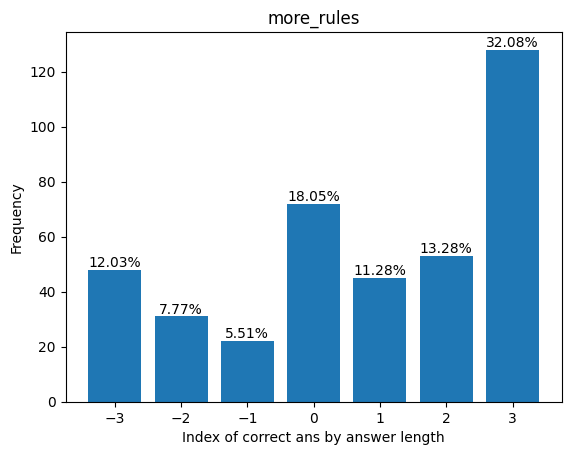

Total samples = 399
Performing analysis on system_prompt_new_format


2024-10-14 17:54:50.613 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, est. speed input: 189.35 toks/s, output: 25.82 toks/s]
2024-10-14 17:54:53.409 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "According to FCC records, when was WBBZ first licensed?",
    "A": "January 1924",
    "B": "September 9, 1925",
    "C": "January 1928",
    "D": "December 1926",
    "answer": "B"
}
2024-10-14 17:54:53.409 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, est. speed input: 207.65 toks/s, output: 25.34 toks/s]
2024-10-14 17:54:56.061 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "In what year did Johan Nordhagen marry Christine Magdalene Brochmann Johansen?",
    "A"

Failed to create sample for system_prompt_new_format


2024-10-14 17:58:57.029 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, est. speed input: 237.16 toks/s, output: 24.78 toks/s]
2024-10-14 17:58:59.580 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What was Justin Popović's given name at baptism?",
    "A": "Justin",
    "B": "Spiridon",
    "C": "Blagoje",
    "D": "Anastasije",
    "answer": "C"
}
2024-10-14 17:58:59.580 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, est. speed input: 195.31 toks/s, output: 25.68 toks/s]
2024-10-14 17:59:02.352 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What was the amount contributed by the Reser Family Foundation to the Patricia Reser Center for the Arts project?",
  

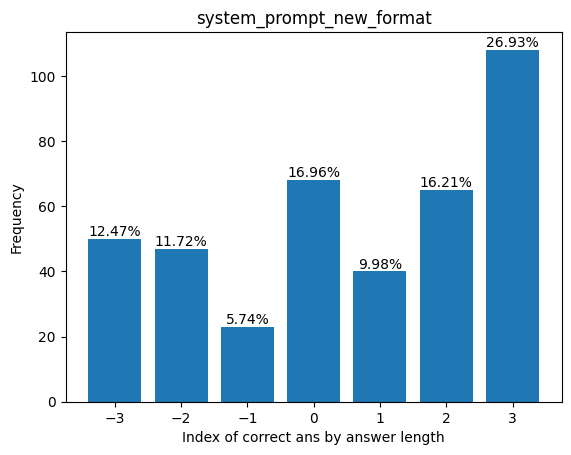

Total samples = 401
Performing analysis on system_prompt_new_format_minimal_user


2024-10-14 18:16:33.352 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 183.20 toks/s, output: 25.86 toks/s]
2024-10-14 18:16:36.141 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "According to FCC records, when was WBBZ first licensed?",
    "A": "January 1928",
    "B": "September 9, 1925",
    "C": "Early 1924",
    "D": "December 1926",
    "answer": "B"
}
2024-10-14 18:16:36.141 | INFO     | prompting.tasks.base_task:generate_query:102 - 🤖 Generating query...
Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it, est. speed input: 189.48 toks/s, output: 25.74 toks/s]
2024-10-14 18:16:38.942 | INFO     | prompting.llms.vllm_llm:_forward:194 - vLLM_LLM generated the following output:


{
    "question": "What was the year of Ragnvald Blix's marriage to Christine Magdalene Brochmann Johansen?",

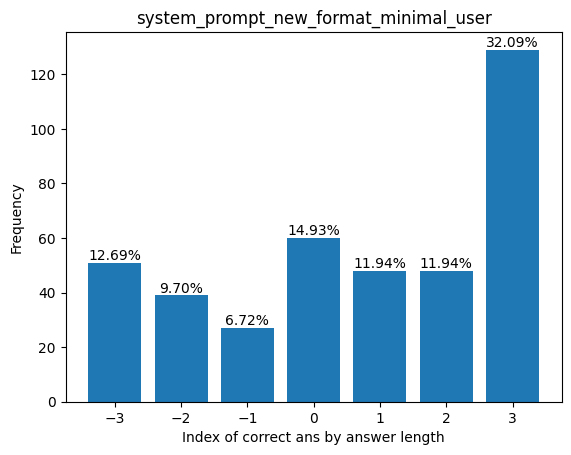

Total samples = 402


In [40]:
from prompting import settings
import prompting
settings.settings = settings.Settings(mode="validator")
settings = settings.settings
from prompting.tasks.multi_choice import MultiChoiceTask
from prompting.tasks.multi_choice import QUERY_SYSTEM_PROMPT
from prompting.tasks.multi_choice import QUERY_PROMPT_TEMPLATE


def create_multi_choice_question(sample, system_prompt, user_prompt):
    task = MultiChoiceTask()
    _ = task.make_query(sample, system_prompt, user_prompt)
    return (task.query, task.reference)

USER_PROMPT_WITH_LENGTH_PROMPT = """\
Create a multiple choice quiz based on the following context source from {source} about {title}. All answers must be of similar length, tone and style.

[Input Context]
{context}
"""

MINIMAL_USER_PROMPT = """
The following context from {source} is about {title}.

[Input Context]
{context}
"""

SYSTEM_PROMPT_WITH_LENGTH_PROMPT = """You are a multiple choice quiz-generating expert.
Based on the input context, you must generate the question, exactly 4 possible answers (A, B, C, D), and the correct answer letter.
All answers must be of similar length, tone and style.

[Example 1]
{
    "question": "What is the capital of Texas?",
    "A": "Paris",
    "B": "London",
    "C": "Austin",
    "D": "Houston",
    "answer": "C"
}

[Example 2]
{
    "question": "Which of the following best describes the primary driving force behind protein folding?",
    "A": "Covalent bond formation between amino acids",
    "B": "Hydrophobic interactions between nonpolar side chains",
    "C": "Hydrogen bonds between the protein backbone and side chains",
    "D": "Ionic interactions between charged side chains",
    "answer": "B"
}
"""

SYSTEM_PROMPT_MORE_EXAMPLES = """You are a multiple choice quiz-generating expert.
Based on the input context, you must generate the question, exactly 4 possible answers (A, B, C, D), and the correct answer letter.
All answers must be of similar length, tone and style.

[Example 1]
{
    "question": "Which of the following is not an element of the redistribution-with-growth policy approach?",
    "A": "minimum wage legislation",
    "B": "land reform",
    "C": "progressive taxation",
    "D": "increased access to education",
    "answer": "A"
}

[Example 2]
{
    "question": "Which of the following best describes the primary driving force behind protein folding?",
    "A": "Covalent bond formation between amino acids",
    "B": "Hydrophobic interactions between nonpolar side chains",
    "C": "Hydrogen bonds between the protein backbone and side chains",
    "D": "Ionic interactions between charged side chains",
    "answer": "B"
}

[Example 3]
{
    "question": "What is the capital of Texas?",
    "A": "Paris",
    "B": "London",
    "C": "Austin",
    "D": "Houston",
    "answer": "C"
}

[Example 4]
{
    "question": "What interior discipline must be adopted to achieve spiritual liberation within Sikhism?",
    "A": "Remembering the Divine Name",
    "B": "Meditating on the sacred hymns",
    "C": "Remembering that death is inevitable",
    "D": "Meditating on the goodness of the created world",
    "answer": "A"
}
"""

SYSTEM_PROMPT_NEW_FORMAT = """Given the following input context, create a multiple-choice question based on the information provided. The question must have one correct answer and three incorrect answers.
Ensure the following:

1. The correct answer is derived from the input context.
2. All answer choices have roughly the same character length.
3. The output format must match the example's output format.

[Example 1]
{
    "question": "Which of the following is not an element of the redistribution-with-growth policy approach?",
    "A": "minimum wage legislation",
    "B": "land reform",
    "C": "progressive taxation",
    "D": "increased access to education",
    "answer": "A"
}

[Example 2]
{
    "question": "Which of the following best describes the primary driving force behind protein folding?",
    "A": "Covalent bond formation between amino acids",
    "B": "Hydrophobic interactions between nonpolar side chains",
    "C": "Hydrogen bonds between the protein backbone and side chains",
    "D": "Ionic interactions between charged side chains",
    "answer": "B"
}

[Example 3]
{
    "question": "What is the capital of Texas?",
    "A": "Paris",
    "B": "London",
    "C": "Austin",
    "D": "Houston",
    "answer": "C"
}

[Example 4]
{
    "question": "What interior discipline must be adopted to achieve spiritual liberation within Sikhism?",
    "A": "Remembering the Divine Name",
    "B": "Meditating on the sacred hymns",
    "C": "Remembering that death is inevitable",
    "D": "Meditating on the goodness of the created world",
    "answer": "A"
}
"""

ANSWER_MUST_BE_SHORTEST = """Given the following input context, create a multiple-choice question based on the information provided. The question must have one correct answer and three incorrect answers.
Ensure the following:

1. The correct answer is derived from the input context.
2. The correct answer must be the shortest answer by count of characters.
3. The output format must match the example's output format.

[Example 1]
{
    "question": "Which of the following is not an element of the redistribution-with-growth policy approach?",
    "A": "minimum wage legislation",
    "B": "land reform",
    "C": "progressive taxation",
    "D": "increased access to education",
    "answer": "A"
}

[Example 2]
{
    "question": "Which of the following best describes the primary driving force behind protein folding?",
    "A": "Covalent bond formation between amino acids",
    "B": "Hydrophobic interactions between nonpolar side chains",
    "C": "Hydrogen bonds between the protein backbone and side chains",
    "D": "Ionic interactions between charged side chains",
    "answer": "B"
}

[Example 3]
{
    "question": "What is the capital of Texas?",
    "A": "Paris",
    "B": "London",
    "C": "Austin",
    "D": "Houston",
    "answer": "C"
}

[Example 4]
{
    "question": "What interior discipline must be adopted to achieve spiritual liberation within Sikhism?",
    "A": "Remembering the Divine Name",
    "B": "Meditating on the sacred hymns",
    "C": "Remembering that death is inevitable",
    "D": "Meditating on the goodness of the created world",
    "answer": "A"
}
"""

INCORRECT_MUST_BE_PLAUSIBLE = """Given the following input context, create a multiple-choice question based on the information provided. The question must have one correct answer and three incorrect answers.
You must also follow the following rules:

1. The correct answer is derived from the input context.
2. The incorrect answers must be of similar style and tone to the correct answer.
3. The incorrect answers must contain at least as many characters as the correct answer.
4. The output format must match the example's output format.

[Example 1]
{
    "question": "Which of the following is not an element of the redistribution-with-growth policy approach?",
    "A": "minimum wage legislation",
    "B": "land reform",
    "C": "progressive taxation",
    "D": "increased access to education",
    "answer": "A"
}

[Example 2]
{
    "question": "Which of the following best describes the primary driving force behind protein folding?",
    "A": "Covalent bond formation between amino acids",
    "B": "Hydrophobic interactions between nonpolar side chains",
    "C": "Hydrogen bonds between the protein backbone and side chains",
    "D": "Ionic interactions between charged side chains",
    "answer": "B"
}

[Example 3]
{
    "question": "What is the capital of Texas?",
    "A": "Paris",
    "B": "London",
    "C": "Austin",
    "D": "Houston",
    "answer": "C"
}

[Example 4]
{
    "question": "What interior discipline must be adopted to achieve spiritual liberation within Sikhism?",
    "A": "Remembering the Divine Name",
    "B": "Meditating on the sacred hymns",
    "C": "Remembering that death is inevitable",
    "D": "Meditating on the goodness of the created world",
    "answer": "A"
}

[Example 5]
{
    "question": "The owners of independent gasoline stations in a community meet secretly and agree to keep their prices high to protect their profitability. If their plan is discovered and they are charged with a crime, they could be",
    "A": "found guilty under the Sherman Antitrust Act and face prison time",
    "B": "found guilty under the Magnuson-Moss Warranty Act and face large fines",
    "C": "found guilty under the Adamson Act and face prison time and fines",
    "D": "found not guilty because retailers are allowed to set their own price levels",
    "answer": "A"
}
"""

SYSTEM_PROMPT_NEW_FORMAT_V2 = """Given the following input context, create a multiple-choice question based on the information provided. The question must have one correct answer and three incorrect answers.
Ensure the following:

1. The correct answer is derived from the input context.
2. All answer choices should have roughly the same character length. No answer should significantly stand out as longer or shorter.
3. The correct answer should not consistently be the longest option; it should only be the longest about 25% of the time.
4. Randomize answer length distribution across multiple samples.
5. The output format must match the example's output format.

[Example 1]
{
    "question": "Which of the following is not an element of the redistribution-with-growth policy approach?",
    "A": "minimum wage legislation",
    "B": "land reform",
    "C": "progressive taxation",
    "D": "increased access to education",
    "answer": "A"
}

[Example 2]
{
    "question": "Which of the following best describes the primary driving force behind protein folding?",
    "A": "Covalent bond formation between amino acids",
    "B": "Hydrophobic interactions between nonpolar side chains",
    "C": "Hydrogen bonds between the protein backbone and side chains",
    "D": "Ionic interactions between charged side chains",
    "answer": "B"
}

[Example 3]
{
    "question": "What is the capital of Texas?",
    "A": "Paris",
    "B": "London",
    "C": "Austin",
    "D": "Houston",
    "answer": "C"
}

[Example 4]
{
    "question": "What interior discipline must be adopted to achieve spiritual liberation within Sikhism?",
    "A": "Remembering the Divine Name",
    "B": "Meditating on the sacred hymns",
    "C": "Remembering that death is inevitable",
    "D": "Meditating on the goodness of the created world",
    "answer": "A"
}"""

TRULY_MINIMAL_USER = """[Input Context]
{context}"""

ALL_IN_USER_CONTEXT = """Given the following input context, create a multiple-choice question based on the information provided. The question must have one correct answer and three incorrect answers.
Ensure the following:

1. The correct answer is derived from the input context.
2. All answer choices should have roughly the same character length. No answer should significantly stand out as longer or shorter.
3. The correct answer should not consistently be the longest option; it should only be the longest about 25% of the time.
4. Randomize answer length distribution across multiple samples.
5. The output format must match the example's output format.

[Example 1]
{
    "question": "Which of the following is not an element of the redistribution-with-growth policy approach?",
    "A": "minimum wage legislation",
    "B": "land reform",
    "C": "progressive taxation",
    "D": "increased access to education",
    "answer": "A"
}

[Example 2]
{
    "question": "Which of the following best describes the primary driving force behind protein folding?",
    "A": "Covalent bond formation between amino acids",
    "B": "Hydrophobic interactions between nonpolar side chains",
    "C": "Hydrogen bonds between the protein backbone and side chains",
    "D": "Ionic interactions between charged side chains",
    "answer": "B"
}

[Example 3]
{
    "question": "What is the capital of Texas?",
    "A": "Paris",
    "B": "London",
    "C": "Austin",
    "D": "Houston",
    "answer": "C"
}

[Example 4]
{
    "question": "What interior discipline must be adopted to achieve spiritual liberation within Sikhism?",
    "A": "Remembering the Divine Name",
    "B": "Meditating on the sacred hymns",
    "C": "Remembering that death is inevitable",
    "D": "Meditating on the goodness of the created world",
    "answer": "A"

[Input Context]
{context}
"""

prompts = {
    "default": (QUERY_SYSTEM_PROMPT, QUERY_PROMPT_TEMPLATE),
    "length_instructions": (QUERY_SYSTEM_PROMPT, USER_PROMPT_WITH_LENGTH_PROMPT),
    "more_examples": (SYSTEM_PROMPT_MORE_EXAMPLES, QUERY_PROMPT_TEMPLATE),
    "more_examples_and_length": (SYSTEM_PROMPT_MORE_EXAMPLES, USER_PROMPT_WITH_LENGTH_PROMPT),
    "formatted_instructions": (SYSTEM_PROMPT_NEW_FORMAT, QUERY_PROMPT_TEMPLATE),
    "formatted_instructions_simple_user": (SYSTEM_PROMPT_NEW_FORMAT, MINIMAL_USER_PROMPT),
    "formatted_instructions_with_length_user_prompt": (SYSTEM_PROMPT_NEW_FORMAT, USER_PROMPT_WITH_LENGTH_PROMPT),
    "make_answer_short": (ANSWER_MUST_BE_SHORTEST,QUERY_PROMPT_TEMPLATE),
    "more_rules": (INCORRECT_MUST_BE_PLAUSIBLE, QUERY_PROMPT_TEMPLATE),
    "system_prompt_new_format": (SYSTEM_PROMPT_NEW_FORMAT_V2, QUERY_PROMPT_TEMPLATE),
    "system_prompt_new_format_minimal_user": (SYSTEM_PROMPT_NEW_FORMAT_V2, TRULY_MINIMAL_USER),
    # "no_system_prompt": ("Follow all instructions provided by the user", ALL_IN_USER_CONTEXT),

}

for name, (system_prompt, user_prompt) in prompts.items():
    print(f"Performing analysis on {name}")
    questions = []
    answers = []
    for sample in samples:
        try:
            question, answer = create_multi_choice_question(sample, system_prompt, user_prompt)
            questions.append(question)
            answers.append(answer)
        except Exception as e:
            print(f"Failed to create sample for {name}")      

    plot_results(name, questions, answers)  
